In [20]:
import glob as glob
import os
import numpy as np
import mne 
import shutil
from mne.datasets import eegbci
from mne.datasets import sleep_physionet
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
df_SC = pd.read_csv('D:\Sleep-EDF Database Expanded\sleep-edf-database-expanded-1.0.0\SC-subjects.xls',delimiter=';', encoding='ISO-8859-1').fillna(0)
df_ST = pd.read_csv('D:\Sleep-EDF Database Expanded\sleep-edf-database-expanded-1.0.0\ST-subjects.xls',delimiter=';', encoding='ISO-8859-1').fillna(0)

In [22]:
df=pd.read_csv("D:\Sleep-EDF Database Expanded\sleep-edf-database-expanded-1.0.0\SHA256SUMS.txt")

In [23]:
data_dir_sleeptelemetry = 'D:\Sleep-EDF Database Expanded\sleep-edf-database-expanded-1.0.0\sleep-telemetry'

# Find all PSG and hypnogram files in the directory
psg_files = [f for f in os.listdir(data_dir_sleeptelemetry ) if f.endswith('PSG.edf')]
hyp_files = [f for f in os.listdir(data_dir_sleeptelemetry ) if f.endswith('Hypnogram.edf')]

print(len(data_dir_sleeptelemetry))

80


In [24]:
raw_list = []
for f in psg_files:
    raw = mne.io.read_raw_edf(os.path.join(data_dir_sleeptelemetry , f), preload=True, verbose=0, stim_channel='Event marker', infer_types=True, misc=['Temp rectal'])
    raw_list.append(raw)

# Merge raw objects
raw = mne.concatenate_raws(raw_list)

In [25]:
import warnings

for i, raw in enumerate(raw_list):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        annot = mne.read_annotations(os.path.join(data_dir_sleeptelemetry, hyp_files[i]))
    groups_list = raw.set_annotations(annot)
print(groups_list[1])

C:\Users\nguye\AppData\Local\Temp\ipykernel_14708\1995517618.py:7: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  groups_list = raw.set_annotations(annot)
C:\Users\nguye\AppData\Local\Temp\ipykernel_14708\1995517618.py:7: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  groups_list = raw.set_annotations(annot)
C:\Users\nguye\AppData\Local\Temp\ipykernel_14708\1995517618.py:7: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  groups_list = raw.set_annotations(annot)
C:\Users\nguye\AppData\Local\Temp\ipykernel_14708\1995517618.py:7: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  groups_list = raw.set_annotations(annot)
C:\Users\nguye\AppData\Local\Temp\ipykernel_14708\1995517618.py:7: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  groups_list = raw.set_annotations(annot)


(array([[ 2.36220472e-05,  2.36220472e-05,  2.36220472e-05, ...,
        -2.82384179e-03, -2.82384179e-03, -2.82384179e-03]]), array([0.000000e+00, 1.000000e-02, 2.000000e-02, ..., 2.947997e+04,
       2.947998e+04, 2.947999e+04]))


In [ ]:
data, times = raw.get_data(return_times=True)
print(data.shape)
print(times.shape)

In [ ]:
print(raw.time_as_index(20))
print(raw.time_as_index([20, 30, 40]), '\n')
print(np.diff(raw.time_as_index([1, 2, 3])))

In [ ]:
events, event_dict = mne.events_from_annotations(raw)
print(event_dict)
print(events[:5])

In [ ]:
def sleep_quality(raw):
    # resample the data to 120 Hz
    raw.resample(120, npad='auto')
    # extract the sleep stages array
    stages = raw.annotations.description
    #Total Recording Time(TRT)
    if type(stages)==list:
        stages = np.array(stages)
    TRT = len(stages)*30/60
    # print('Predicted Total Recording Time in minutes:',TRT)
    #Number of Each Stage
    N1_index = np.where(stages==1)[0]
    Num_N1 = len(N1_index)
    N2_index = np.where(stages==2)[0]
    Num_N2 = len(N2_index)
    N3_index = np.where(stages==3)[0]
    Num_N3 = len(N3_index)
    R_index = np.where(stages==4)[0]
    Num_R = len(R_index)
    #Total Sleep Time(TST) in min
    TST = round((Num_N1 + Num_N2 + Num_N3 + Num_R) * 30/60,2)
    # print('Total Sleep Time in minutes:',TST)
    #Percentage of each sleep stage
    N1_per = round((Num_N1*30/60)/TST,3)
    N2_per = round((Num_N2*30/60)/TST,3)
    D_per = round((Num_N3*30/60)/TST,3)
    R_per = round((Num_R*30/60)/TST,3)
    NREM_per = round(((Num_N1+Num_N2+Num_N3)*30/60)/TST,3)
    
    #Sleep Efficiency
    SE_per = TST/TRT
    # SE_per = SE_per*100
    SE = round(SE_per,3)
    # print('The normal sleep efficiency of adults should be bigger than 90%')
    # print('Sleep Efficiency:{}'.format(SE))
    #Deep Sleep Time(DST) in minutes
    
    # print('All Deep Sleep Time in minutes:',SWST)
    # print('Deep Sleep Percentage:',DSP)
    #REM Sleep Time(RST) in minutes
    
    # print('All REM Sleep Time in minutes:',RST)
    # print('REM Sleep Perentage:{}'.format(RSP))
    #Low Sleep Time(LST)
    LST = (Num_N1 + Num_N2) * 30/60
    # print('All Low Sleep Time in minutes:',LST)
    #Sleep Latency(SL) and REM Latency
    ##find index of the first sleep stage
    # print('The normal REM latency of adults should be between 90 and 120 minutes')
    
    lab_type,lab_count = np.unique(stages,return_counts=True)
    
    first_nonzero_ind = np.nonzero(stages)[0][0]
    last_nonzero_ind = np.nonzero(stages)[0][-1]
    if Num_R == 0:
        print('This subject does not have REM sleep stages')
        RL = 0
    else:
        firstRIndex = list(stages).index(4)
        RL = (firstRIndex-first_nonzero_ind)*30/60
        
    #Sleep Period Time(SPT). Note: it refers to the time from sleep onset to the last sleep epoch, including WAS

Used Annotations descriptions: ['Movement time', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


C:\Users\nguye\AppData\Local\Temp\ipykernel_14708\2943270317.py:22: RuntimeWarning: event 7 missing from event_id will be ignored
  fig = mne.viz.plot_events(events_train, event_id=event_id,


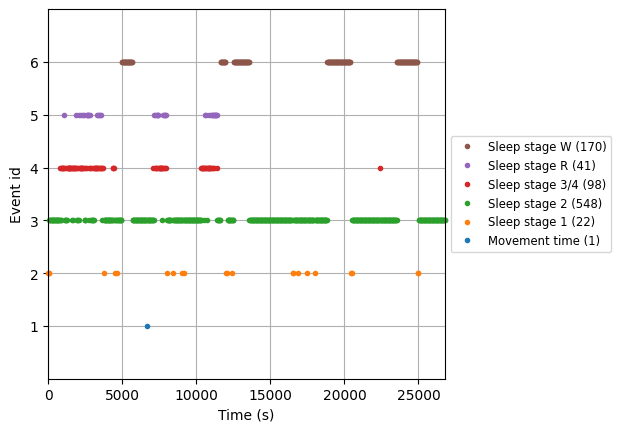

In [26]:
annotation_desc_2_event_id = {'Movement time': 1, 'Sleep stage 1': 2, 'Sleep stage 2': 3, 'Sleep stage 3': 4, 'Sleep stage 4': 5, 'Sleep stage R': 6, 'Sleep stage W': 7}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
annot.crop(annot[1]['onset'] - 30 * 60,
                 annot[-2]['onset'] + 30 * 60)

raw.set_annotations(annot, emit_warning=False)

events_train, _ = mne.events_from_annotations(
    raw, event_id=annotation_desc_2_event_id, chunk_duration=30.)

# create a new event_id that unifies stages 3 and 4
event_id = {'Sleep stage W': 6,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5,
            'Movement time': 1}

# plot events
fig = mne.viz.plot_events(events_train, event_id=event_id,
                          sfreq=raw.info['sfreq'],
                          first_samp=events_train[0, 0]);

# keep the color-code for further plotting
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
print(raw.ch_names)

In [ ]:
print(raw_list[0].annotations)

In [ ]:
print(events_train)

In [27]:
n_time_samps = raw.n_times
time_secs = raw.times
ch_names = raw.ch_names
n_chan = len(ch_names)  # note: there is no raw.n_channels attribute
print('the (cropped) sample data object has {} time samples and {} channels.'
      ''.format(n_time_samps, n_chan))
print('The last time sample is at {} seconds.'.format(time_secs[-1]))
print('The first few channel names are {}.'.format(', '.join(ch_names[:3])))
print()  # insert a blank line in the output

# some examples of raw.info:
print('bad channels:', raw.info['bads'])  # chs marked "bad" during acquisition
print(raw.info['sfreq'], 'Hz')            # sampling frequency
print(raw.info['description'], '\n')      # miscellaneous acquisition info

print(raw.info)

the (cropped) sample data object has 2948000 time samples and 5 channels.
The last time sample is at 29479.99 seconds.
The first few channel names are Fpz-Cz, Pz-Oz, horizontal.

bad channels: []
100.0 Hz
None 

<Info | 7 non-empty values
 bads: []
 ch_names: Fpz-Cz, Pz-Oz, horizontal, submental, Marker
 chs: 3 EEG, 1 EOG, 1 EMG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 800.0 Hz
 meas_date: 1994-09-15 23:35:00 UTC
 nchan: 5
 projs: []
 sfreq: 100.0 Hz
>


In [ ]:
print(len(raw.annotations))
print(set(raw.annotations.duration))
print(set(raw.annotations.description))
print(raw.annotations.onset[0])

In [35]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.3, 4],
                  "theta": [4, 8],
                  "alpha": [8, 13],
                  "sigma": [11.5, 15.5],
                  "beta": [13, 30]}

    spectrum = epochs.compute_psd(picks=raw.info['ch_names'], fmin=0.3, fmax=30., n_jobs=1)
    psds, freqs = spectrum.get_data(return_freqs=True)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.sparse import coo_matrix

tmax = 30. - 1. / raw.info['sfreq']  # tmax in included

# Create epochs from the raw data and events
epochs = mne.Epochs(raw=raw, events=events_train, event_id=event_id,
                     tmin=0., tmax=tmax, baseline=None, preload=True)

# Filter the epochs and apply other preprocessing steps
epochs.filter(l_freq=0.3, h_freq=30)

# Get the unique labels of the events in the data
labels = epochs.events[:, 2]
unique_labels = np.unique(labels)

# Use LabelEncoder to transform the labels into integers
le = LabelEncoder()
le.fit(unique_labels)
int_labels = le.transform(labels)

# Use OneHotEncoder to transform the integer labels into one-hot encoded vectors
ohe = OneHotEncoder()
ohe.fit(np.arange(len(unique_labels)).reshape(-1, 1))
one_hot_labels = ohe.transform(int_labels.reshape(-1, 1))

# Convert the one-hot encoded labels to a dense array
y = coo_matrix(one_hot_labels).toarray()

# Split the data into training and testing sets
indices = np.arange(len(epochs))
train_indices, test_indices, y_train, y_test = train_test_split(indices, y, test_size=0.3, random_state=123) 


train_epochs = epochs[train_indices]
test_epochs = epochs[test_indices]

print("Number of training epochs:", len(train_epochs))
print("Number of testing epochs:", len(test_epochs))


Not setting metadata
880 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 880 events and 3000 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 0.3 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1101 samples (11.010 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Number of training epochs: 616
Number of testing epochs: 264


[Parallel(n_jobs=1)]: Done 2640 out of 2640 | elapsed:    1.2s finished


In [ ]:
print(indices)

In [ ]:
print(train_epochs)

In [ ]:
print(test_epochs)

In [ ]:
# visualize PSD by sleep stage
fig, ax = plt.subplots()
stages = sorted(event_id.keys())
for i in range(len(test_epochs)):
    spectrum = test_epochs[i].copy().crop(0, 120).plot_psd(fmin=0.1, fmax=20., ax=ax, color=stage_colors[i],
                                                          show=False, average=True, spatial_colors=False)
ax.set(title='PSD by sleep stage', xlabel='Frequency (Hz)', ylabel='µV²/Hz (dB)')
ax.legend(ax.lines[2::3], stages)
plt.show()

In [ ]:
# Concatenate the individual test epochs
epochs_test = mne.concatenate_epochs(test_epochs)

# Get the event counts for each sleep stage
event_counts = epochs_test.event_id.copy()
for sleep_stage in event_counts:
    event_counts[sleep_stage] = len(epochs_test[event_counts[sleep_stage]])

# Print the final result
print(epochs_test)
print(event_counts)

In [ ]:
# Concatenate the individual test epochs
epochs_train = mne.concatenate_epochs(train_epochs)

# Get the event counts for each sleep stage
event_counts = epochs_train.event_id.copy()
for sleep_stage in event_counts:
    event_counts[sleep_stage] = len(epochs_train[event_counts[sleep_stage]])

# Print the final result
print(epochs_train)
print(event_counts)

In [ ]:
X_train = []
for epoch in train_epochs:
    data = train_epochs.get_data()
    X_train.append(data.reshape(data.shape[0], -1))

X_train = np.concatenate(X_train, axis=0)

X_test = []
for epoch in test_epochs:
    data = test_epochs.get_data()
    X_test.append(data.reshape(data.shape[0], -1))

X_test = np.concatenate(X_test, axis=0)

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from tensorflow.keras.utils import to_categorical

# define the pipeline
pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
                     HistGradientBoostingClassifier(random_state=123))

# train the pipeline
y_train = train_epochs.events[:, 2]
pipe.fit(train_epochs, y_train)

# test the pipeline
y_pred = pipe.predict(test_epochs)

# assess the results
y_test = test_epochs.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {:.2f}%".format(acc * 100))

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Accuracy score: 81.06%


In [ ]:
print(y_train)

In [ ]:
print(confusion_matrix(y_test, y_pred))

In [ ]:
event_id.keys()

In [ ]:
print(classification_report(y_test, y_pred, target_names=event_id.keys()))

In [ ]:
print(y_pred)

In [ ]:
print(np.unique(y_test))
print(np.unique(y_pred))

In [38]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

# Define the bagging classifier with a random forest base estimator
bagging_clf = BaggingClassifier(base_estimator=RandomForestClassifier(max_depth=5), n_estimators=10, random_state=123)

# Define the pipeline with feature engineering and bagging classifier
pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False), bagging_clf)

# Extract labels from epochs
y_train = train_epochs.events[:, 2]
y_test = test_epochs.events[:, 2]

# Fit the pipeline to the training data
pipe.fit(train_epochs, y_train)

# Make predictions on the test data
y_pred = pipe.predict(test_epochs)

# Evaluate the accuracy of the predictions
accuracy = accuracy_score(y_test.ravel(), y_pred)
print("Accuracy score: {:.2f}%".format(accuracy * 100))

    Using multitaper spectrum estimation with 7 DPSS windows


f:\File Visual studio\File python 3.10\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


    Using multitaper spectrum estimation with 7 DPSS windows
Accuracy score: 79.17%


In [ ]:
print(y_train, y_test)

In [ ]:
epochs_data = epochs.get_data()
print(epochs_data.shape)

In [ ]:
epochs_data = epochs.get_data()  # convert Epochs object to numpy array
n_channels, n_samples = epochs_data.shape[1:]
print(n_chan ,n_samples)